# Segmenting and Clustering Neighborhoods in Toronto, ON. Canada.


## Introduction

In this assignment, I will be converting addresses into their equivalent latitude and longitude values. Also, I will use the Foursquare API to explore neighborhoods in Toronto. I will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I will use the _k_-means clustering algorithm to complete this task. Finally, I will use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Download and Explore Dataset</a> 

2.  <a href="#item3">Analyze Each Neighborhood</a>

3.  <a href="#item4">Cluster Neighborhoods</a>

4.  <a href="#item5">Examine Clusters</a>  
    </font>
    </div>


Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>


## 1. Explore Dataset


Using the data from previous tasks...

In [2]:
neighbourhoods = pd.read_csv('toronto_boroughs.csv')
neighbourhoods.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


Quickly examine the resulting dataframe.


In [3]:
n_boroughs = len(neighbourhoods['Borough'].unique())
n_neighbourhoods = neighbourhoods.shape[0]
print(f'The dataframe has {n_boroughs} boroughs and {n_neighbourhoods} neighbourhoods')

The dataframe has 10 boroughs and 217 neighbourhoods


#### Use geopy library to get the latitude and longitude values of the Greater Toronto Area.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>toronto_explorer</em>, as shown below.


In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude # Used to centralize the map in Toronto
longitude = location.longitude # Used to centralize the map in Toronto
print(f'The geograpical coordinates of Toronto are {latitude}, {longitude}.')

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.


In [5]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Borough'], neighbourhoods['Neighbourhood']):
    label = f'{neighbourhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.


However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in which boroughs contains the word Toronto. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [6]:
toronto_boroughs = neighbourhoods[neighbourhoods['Borough'].str.contains('Toronto', regex=False, case=False, na=False)].reset_index(drop=True)
toronto_boroughs.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
1,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
2,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
3,M7A,Downtown Toronto,Ontario Provincial Government,43.662301,-79.389494
4,M5B,Downtown Toronto,Garden District,43.657162,-79.378937


As we did with all of all GTA, let's visualizate Toronto neighborhoods in it.

In [7]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_boroughs['Latitude'], toronto_boroughs['Longitude'], toronto_boroughs['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version


In [8]:
CLIENT_ID = 'OP0QM0PATS4BZLY5JNGOXK3Q5MIWYXJA3HLTATWSTPANOAJX' # my Foursquare ID
CLIENT_SECRET = 'VNZ2TFHTMR1X5TXEDBRLWHZTEWFS0LHA00DCUKP4XM4H2B3F' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OP0QM0PATS4BZLY5JNGOXK3Q5MIWYXJA3HLTATWSTPANOAJX
CLIENT_SECRET:VNZ2TFHTMR1X5TXEDBRLWHZTEWFS0LHA00DCUKP4XM4H2B3F


## 2. Explore Neighborhoods in Toronto


#### Let's create a function to repeat the process of gathering the venues of all the neighborhoods in Toronto Area


In [9]:
def get_nearby_venues(names, latitudes, longitudes, radius=500):
    """
    inputs: names/latitudes/longitudes (pd.Series of values)
    This function will iterate over the names and coordinates 
    of all the neighbourhoods in GTA and return the venues
    in a radius of 500 metres of each neighbourhood (its central point)
    """
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={LIMIT}'
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _manhattan_venues_.


In [10]:
# type your answer here
toronto_venues = get_nearby_venues(names = toronto_boroughs['Neighbourhood'],
                                   latitudes = toronto_boroughs['Latitude'],
                                   longitudes = toronto_boroughs['Longitude'])

Regent Park
Harbourfront
Queen's Park
Ontario Provincial Government
Garden District
Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond
Adelaide
King
Dufferin
Dovercourt Village
Harbourfront East
Union Station
Toronto Islands
Little Portugal
Trinity
The Danforth West
Riverdale
Toronto Dominion Centre
Design Exchange
Brockton
Parkdale Village
Exhibition Place
India Bazaar
The Beaches West
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
Forest Hill Road Park
High Park
The Junction South
North Toronto West
 Lawrence Park
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
University of Toronto
Harbord
Runnymede
Swansea
Moore Park
Summerhill East
Kensington Market
Chinatown
Grange Park
Summerhill West
Rathnelly
South Hill
Forest Hill SE
Deer Park
CN Tower
King and Spadina
Railway Lands
Harbourfront West
Bathurst Quay
South Niagara
Island airport
Rosedale
Stn A PO Boxes
St. James To

#### Let's check the size of the resulting dataframe


In [11]:
print(toronto_venues.shape)
toronto_venues.head()

(3233, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Regent Park,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Regent Park,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Regent Park,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Regent Park,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,Regent Park,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Let's check how many venues were returned for each neighborhood


In [12]:
toronto_venues[['Neighbourhood', 'Venue']].groupby('Neighbourhood').count()

,Venue
Neighbourhood,
Lawrence Park,18
Adelaide,100
Bathurst Quay,17
Berczy Park,55
Brockton,25
Business reply mail Processing Centre,16
CN Tower,17
Cabbagetown,50
Central Bay Street,68


#### Let's find out how many unique categories can be curated from all the returned venues


In [13]:
print(f'There are {len(toronto_venues["Venue Category"].unique())} uniques categories.')

There are 240 uniques categories.


<a id='item3'></a>


## 2. Analyze Each Neighborhood


In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Regent Park,0,0,0,0

And let's examine the new dataframe size.


In [15]:
toronto_onehot.shape

(3233, 241)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [16]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Lawrence Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.055556,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.00,0.111111,0.000000,0.111111,0.000000,0.000000,0.0

#### Let's confirm the new size


In [17]:
toronto_grouped.shape

(77, 241)

#### Let's print each neighborhood along with the top 5 most common venues


In [18]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Lawrence Park----
            venue  freq
0     Coffee Shop  0.11
1  Clothing Store  0.11
2     Yoga Studio  0.06
3      Bagel Shop  0.06
4           Diner  0.06


----Adelaide----
         venue  freq
0  Coffee Shop  0.08
1         Café  0.05
2        Hotel  0.04
3          Gym  0.04
4   Restaurant  0.04


----Bathurst Quay----
                 venue  freq
0       Airport Lounge  0.12
1      Airport Service  0.12
2  Rental Car Location  0.06
3          Coffee Shop  0.06
4        Boat or Ferry  0.06


----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.04
2        Beer Bar  0.04
3  Farmers Market  0.04
4     Cheese Shop  0.04


----Brockton----
            venue  freq
0            Café  0.12
1  Breakfast Spot  0.08
2     Coffee Shop  0.08
3       Nightclub  0.08
4       Pet Store  0.04


----Business reply mail Processing Centre----
                  venue  freq
0  Gym / Fitness Center  0.06
1         Auto Workshop  0.06
2           Pizza Place

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append(f'{ind+1}{indicators[ind]} Most Common Venue')
    except:
        columns.append(f'{ind+1}th Most Common Venue')

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lawrence Park,Coffee Shop,Clothing Store,Yoga Studio,Spa,Restaurant,Bagel Shop,Ice Cream Shop,Diner,Sporting Goods Shop,Fast Food Restaurant
1,Adelaide,Coffee Shop,Café,Gym,Restaurant,Hotel,Thai Restaurant,Bar,Clothing Store,Sushi Restaurant,Office
2,Bathurst Quay,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
3,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Seafood Restaurant,Concert Hall,Basketball Stadium
4,Brockton,Café,Breakfast Spot,Nightclub,Coffee Shop,Gym,Playground,Stadium,Bar,Italian Restaurant,Bakery
5,Business reply mail Processing Centre,Light Rail Station,Pizza Place,Brewery,Burrito Place,Butcher,Farmers Market,Fast Food Restaurant,Restaurant,Recording Studio,Auto Workshop
6,CN Tower,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
7,Cabbagetown,Coffee Shop,Pizza Place,Restaurant,Café,Italian Restaurant,Market,Chinese Restaurant,Park,Bakery,Pub
8,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Department Store,Japanese Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant
9,Chinatown,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bar,Coffee Shop,Café,Vietnamese Restaurant,Pizza Place,Park,Burger Joint,Dumpling Restaurant


<a id='item4'></a>


## 3. Cluster Neighborhoods


Use elbow technique to find a good number for ```kclusters```

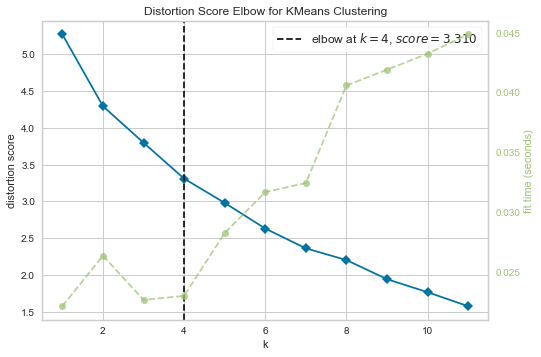

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
from yellowbrick.cluster import KElbowVisualizer

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', axis=1)


# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(1,12))

visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Run _k_-means to cluster the neighborhood into 4 clusters.


In [23]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_boroughs.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head(10) # check the last columns!

toronto_merged.dropna(inplace=True) # Dropping the neighbourhoods with no venues

Finally, let's visualize the resulting clusters


In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[int(cluster)-1],
        fill = True,
        fill_color = rainbow[int(cluster)-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


## 4. Examine Clusters


Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 1


In [26]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
1,Downtown Toronto,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
2,Downtown Toronto,0,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
3,Downtown Toronto,0,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
4,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
5,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bookstore,Pizza Place,Middle Eastern Restaurant
6,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Cocktail Bar,Gastropub,Bakery,Beer Bar,American Restaurant,Japanese Restaurant,Italian Restaurant
7,East Toronto,0,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
8,Downtown Toronto,0,Coffee Shop,Bakery,Cocktail Bar,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Seafood Restaurant,Concert Hall,Basketball Stadium
9,Downtown Toronto,0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Department Store,Japanese Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant


#### Cluster 2


In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Central Toronto,1,Sushi Restaurant,Park,Mexican Restaurant,Jewelry Store,Trail,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
37,Central Toronto,1,Sushi Restaurant,Park,Mexican Restaurant,Jewelry Store,Trail,Dive Bar,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
69,Downtown Toronto,1,Park,Trail,Tennis Court,Playground,Donut Shop,Doner Restaurant,Dog Run,Dumpling Restaurant,Deli / Bodega,Dive Bar


#### Cluster 3


In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Downtown Toronto,2,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
63,Downtown Toronto,2,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
64,Downtown Toronto,2,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
65,Downtown Toronto,2,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
66,Downtown Toronto,2,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
67,Downtown Toronto,2,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop
68,Downtown Toronto,2,Airport Lounge,Airport Service,Boutique,Bar,Boat or Ferry,Sculpture Garden,Historic Site,Rental Car Location,Harbor / Marina,Coffee Shop


#### Cluster 4


In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Central Toronto,3,Playground,Trail,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
53,Central Toronto,3,Playground,Trail,Yoga Studio,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
